In [80]:
import numpy as np
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

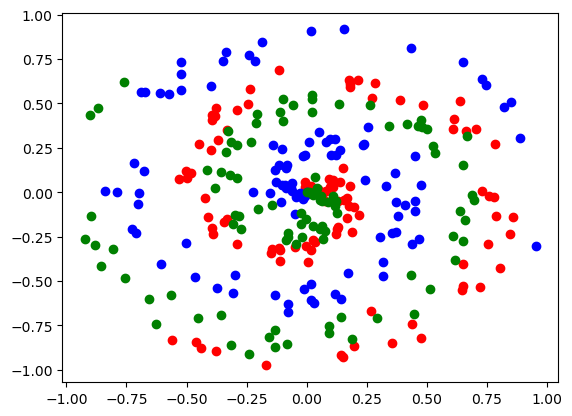

In [81]:
X,y = spiral_data(100,3)
plt.scatter(X[:,0][y == 0],X[:,1][y == 0],c = 'red')
plt.scatter(X[:,0][y == 1],X[:,1][y == 1],c = 'blue')
plt.scatter(X[:,0][y == 2],X[:,1][y == 2],c = 'green')
plt.show()

In [82]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

### Adding Regularization Terms

In [83]:
class Dense:
    def __init__(self,no_of_inputs ,no_of_neurons,weight_regularizer_l1 = 0.0,
                weight_regularizer_l2 = 0.0,bias_regularizer_l1 = 0.0,bias_regularizer_l2 = 0.0):
        self.weights = np.random.randn(no_of_inputs, no_of_neurons) * 0.01
        self.biases = np.zeros((1, no_of_neurons))
        self.weights_momentum = np.zeros_like(self.weights)
        self.biases_momentum = np.zeros_like(self.biases)
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.bias_regularizer_l1 = bias_regularizer_l1        
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l2 = bias_regularizer_l2
        

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)
        
        # L1 Regularization
        if(self.weight_regularizer_l1>0):
            DL1 = np.ones_like(self.weights)
            DL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1*DL1
        if(self.bias_regularizer_l1>0):
            DL1 = np.ones_like(self.biases)
            DL1[self.biases < 0] = -1
            self.dbiases += DL1*self.bias_regularizer_l1

        # L2 Regularization
        if(self.weight_regularizer_l2>0):
            self.dweights += 2*self.weights*self.weight_regularizer_l2
        if(self.bias_regularizer_l2>0):
            self.dbiases += 2*self.dbiases*self.bias_regularizer_l2
        



class ReluActivation:
    def forward(self, dense_output):
        self.inputs = dense_output
        self.output = np.maximum(0, dense_output)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs < 0] = 0


class Softmax:
    def forward(self, inputs):
        exp_inputs = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        sum_exp = np.sum(exp_inputs, axis=1, keepdims=True)
        self.output = exp_inputs / sum_exp
        return self.output


class CrossEntLoss:
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            return -np.mean(np.log(y_pred[range(samples), y_true]))
        elif len(y_true.shape) == 2:
            return -np.mean(np.log(np.sum(y_pred * y_true, axis=1)))


class Softmax_CrossentLoss:
    def __init__(self):
        self.activation = Softmax()
        self.loss = CrossEntLoss()

    def forward(self, inputs, y_true):
        self.softmax_output = self.activation.forward(inputs)
        return self.loss.forward(self.softmax_output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs /= samples

class LOSS:
    def regularization_loss(self,layer):
        regualarization_loss = 0

        if layer.weight_regularizer_l1 >0 :
            regualarization_loss += layer.weight_regularizer_l1*np.sum(np.abs(layer.weights))
        if layer.bias_regularizer_l1 >0 :
            regualarization_loss += layer.bias_regularizer_l1*np.sum(np.abs(layer.biases))
        if layer.weight_regularizer_l2 >0 :
            regualarization_loss += layer.weight_regularizer_l2*np.sum(layer.weights*layer.weights)
        if layer.bias_regularizer_l2 >0 :
            regualarization_loss += layer.bias_regularizer_l2*np.sum(layer.biases*layer.biases)

        return regualarization_loss

In [84]:
class Optimizer_ADAM:
    def __init__(self,learning_rate = 0.001,decay = 0,epsilon = 1e-7,beta1 = 0.9,beta2 = 0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        self.iterations = 0

    def pre_update_params(self):
        self.current_learning_rate = self.learning_rate / (1 + self.decay*self.iterations)

    def update_params(self,layer):
    
        if not hasattr(layer,'weights_momentum'):
            layer.weights_momentum = np.zeros_like(layer.weights)
            layer.biases_momentum = np.zeros_like(layer.biases)
        
        if not hasattr(layer,'weights_cache'):
            layer.weights_cache = np.zeros_like(layer.weights)
            layer.biases_cache = np.zeros_like(layer.biases)

        t = self.iterations +1

        layer.weights_momentum = self.beta1*layer.weights_momentum + (1-self.beta1)*layer.dweights
        layer.biases_momentum = self.beta1*layer.biases_momentum + (1-self.beta1)*layer.dbiases

        weight_momentum_corrected = layer.weights_momentum / ( 1- self.beta1 ** t)
        biases_momentum_corrected = layer.biases_momentum / ( 1- self.beta1 ** t)

        layer.weights_cache = self.beta2 * layer.weights_cache + (1 - self.beta2)*(layer.dweights ** 2)
        layer.biases_cache = self.beta2 * layer.biases_cache + (1 - self.beta2)*(layer.dbiases ** 2)


        weight_cache_corrected = layer.weights_cache / ( 1- self.beta2 ** t)
        biases_cache_corrected = layer.biases_cache / ( 1- self.beta2 ** t)


        layer.weights -= (self.current_learning_rate*weight_momentum_corrected) / \
                          (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases -= (self.current_learning_rate*biases_momentum_corrected) / \
                         (np.sqrt(biases_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

In [88]:
dense1 = Dense(2, 64, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation1 = ReluActivation()

dense2 = Dense(64, 3)
softmax_loss = Softmax_CrossentLoss()

optimizer = Optimizer_ADAM(learning_rate=0.02, decay=5e-7)
regularizer = LOSS()

for epoch in range(15001):

    # Forward
    dense1.forward(x_train)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = softmax_loss.forward(dense2.output, y_train)

    # Regularization
    regularizer_loss = regularizer.regularization_loss(dense1) + regularizer.regularization_loss(dense2)
    total_loss = loss + regularizer_loss

    # Accuracy
    prediction = np.argmax(softmax_loss.softmax_output, axis=1)
    if len(y_train.shape) == 2:
        y_train_labels = np.argmax(y_train, axis=1)
    else:
        y_train_labels = y_train

    accuracy = np.mean(prediction == y_train_labels)

    if epoch % 100 == 0:
        print(f'epoch = {epoch}, loss = {total_loss:.5f}, data_loss = {loss:.5f}, reg_loss = {regularizer_loss:.5f}, acc = {accuracy:.3f}, lr = {optimizer.current_learning_rate}')

    # Backward
    softmax_loss.backward(softmax_loss.softmax_output, y_train)
    dense2.backward(softmax_loss.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

# Evaluation
dense1.forward(x_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = softmax_loss.forward(dense2.output, y_test)

regularizer_loss = regularizer.regularization_loss(dense1) + regularizer.regularization_loss(dense2)
total_loss = loss + regularizer_loss

prediction = np.argmax(softmax_loss.softmax_output, axis=1)
if len(y_test.shape) == 2:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

accuracy = np.mean(prediction == y_test_labels)
print(f'val_loss = {total_loss:.5f}, acc = {accuracy:.3f}')


epoch = 0, loss = 1.09860, data_loss = 1.09859, reg_loss = 0.00001, acc = 0.346, lr = 0.02
epoch = 100, loss = 0.92905, data_loss = 0.90788, reg_loss = 0.02117, acc = 0.546, lr = 0.019999010049002574
epoch = 200, loss = 0.74221, data_loss = 0.68280, reg_loss = 0.05941, acc = 0.721, lr = 0.019998010197985302
epoch = 300, loss = 0.64813, data_loss = 0.56362, reg_loss = 0.08451, acc = 0.792, lr = 0.019997010446938183
epoch = 400, loss = 0.59795, data_loss = 0.50156, reg_loss = 0.09638, acc = 0.800, lr = 0.01999601079584623
epoch = 500, loss = 0.56615, data_loss = 0.46527, reg_loss = 0.10088, acc = 0.825, lr = 0.01999501124469445
epoch = 600, loss = 0.54436, data_loss = 0.44254, reg_loss = 0.10182, acc = 0.833, lr = 0.01999401179346786
epoch = 700, loss = 0.52704, data_loss = 0.42541, reg_loss = 0.10163, acc = 0.850, lr = 0.01999301244215147
epoch = 800, loss = 0.51107, data_loss = 0.40998, reg_loss = 0.10109, acc = 0.858, lr = 0.019992013190730303
epoch = 900, loss = 0.49934, data_loss = 

In [94]:
class Dropout_layer:
    def __init__(self, rate):
        self.rate = 1 - rate  

    def forward(self, inputs, training=True):
        self.inputs = inputs
        if training:
            self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
            self.output = inputs * self.binary_mask
        else:
            self.output = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask


### Adding a Dropout layer

In [95]:
dense1 = Dense(2,64,weight_regularizer_l2=5e-4,bias_regularizer_l2=5e-4)
activation1 = ReluActivation()
dropout1 = Dropout_layer(0.1)

dense2 = Dense(64,3)
softmax_loss = Softmax_CrossentLoss()

optimizer = Optimizer_ADAM(learning_rate=0.05,decay=5e-5)
regularizer = LOSS()

for epochs in range(10001):

    dense1.forward(x_train)
    activation1.forward(dense1.output)
    dropout1.forward(activation1.output)

    dense2.forward(dropout1.output)
    loss = softmax_loss.forward(dense2.output,y_train)

    
    regularizer_loss = regularizer.regularization_loss(dense1)+ regularizer.regularization_loss(dense2)

    total_loss = loss + regularizer_loss

    prediction = np.argmax(softmax_loss.softmax_output,axis=1)
    if(len(y_train.shape) == 2):
        y_train = np.argmax(y_train,axis=1)

    accuracy = np.mean(prediction == y_train)
    if epochs % 100 == 0:
        print(f'epochs = {epochs}, loss = {total_loss :5f},data_loss = {loss:5f}, regularizer_loss = {regularizer_loss:5f} acc = {accuracy:.3f}, lr = {optimizer.current_learning_rate}')


    softmax_loss.backward(softmax_loss.softmax_output,y_train)
    dense2.backward(softmax_loss.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)


    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()


dense1.forward(x_test)
activation1.forward(dense1.output)

dense2.forward(activation1.output)
loss = softmax_loss.forward(dense2.output,y_test)

regularizer_loss = regularizer.regularization_loss(dense1)+ regularizer.regularization_loss(dense2)

total_loss = loss + regularizer_loss

prediction = np.argmax(softmax_loss.softmax_output,axis=1)
if(len(y_test.shape) == 2):
        y_test = np.argmax(y_test,axis=1)

accuracy = np.mean(prediction == y_test)
if epochs % 100 == 0:
    print(f'val_loss = {total_loss :5f},acc = {accuracy:.3f}')


epochs = 0, loss = 1.098611,data_loss = 1.098605, regularizer_loss = 0.000006 acc = 0.358, lr = 0.05
epochs = 100, loss = 0.981102,data_loss = 0.938600, regularizer_loss = 0.042503 acc = 0.575, lr = 0.04975371909050202
epochs = 200, loss = 0.923124,data_loss = 0.845868, regularizer_loss = 0.077255 acc = 0.608, lr = 0.049507401356502806
epochs = 300, loss = 0.900260,data_loss = 0.801467, regularizer_loss = 0.098793 acc = 0.596, lr = 0.0492635105177595
epochs = 400, loss = 1.040530,data_loss = 0.925675, regularizer_loss = 0.114855 acc = 0.608, lr = 0.04902201088288642
epochs = 500, loss = 0.957883,data_loss = 0.830254, regularizer_loss = 0.127629 acc = 0.588, lr = 0.04878286745694912
epochs = 600, loss = 0.913444,data_loss = 0.773709, regularizer_loss = 0.139734 acc = 0.642, lr = 0.04854604592455945
epochs = 700, loss = 0.947163,data_loss = 0.792751, regularizer_loss = 0.154412 acc = 0.604, lr = 0.048311512633460556
epochs = 800, loss = 0.950602,data_loss = 0.783239, regularizer_loss = 0